<a href="https://www.kaggle.com/code/danielsilvaavila/predicting-ethereum-price?scriptVersionId=109647168" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pp # exploratory data analysis EDA
import matplotlib.pyplot as plt # data visualization
import plotly.express as px #data visualisation
from sklearn.preprocessing import MinMaxScaler #preprocessing
from keras.models import Sequential #neural network
from keras.layers import Dense, LSTM #neural network
from keras.callbacks import EarlyStopping, ModelCheckpoint

This notebook is not finished! 

We'll use the library selenium (and chromiunm) to automatically download the historical ethereum price to this day. Every time the dataset grows (i.e. each day), the training and test set will be redefined.

In [2]:
# install selenium, chromium and its drivers
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver -y
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 995 kB 588 kB/s 
     |████████████████████████████████| 161 kB 36.1 MB/s 
     |████████████████████████████████| 384 kB 27.4 MB/s 
     |████████████████████████████████| 58 kB 3.2 MB/s 
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.12.5
    Uninstalling certifi-2020.12.5:
      Successfully uninstalled certifi-2020.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
earthengine-api 0.1.261 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
Get:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5391 B]
Get:2 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6786 B]
Get:3 http://packages.cloud.googl

In [3]:
#here we set up the driver environment for chrome so it can be used in kaggle notebook
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)

An html inspection on the target webpage  https://ethereumprice.org/history/ showed that there's a script that needs to be executed in order to start the download, the script is triggered through a click on a download icon identified with the  css selector **.fa-download.**
Aditionally, it was found that everytime a date range is specified the url asociated to the webpage its updated following the next sintax:
*...?start=yyyy-mm-dd&end=yyyy-mm-dd&currency=xxx*
This information is then passed to the  mentioned script so the resulting csv contains the information of the specific date range.

In [4]:
#we'll build the url based on what we found previously
from datetime import date
today = date.today()
d1 = today.strftime("%Y-%m-%d")
link = 'https://ethereumprice.org/history/?start=2016-01-01&end='+d1+'&currency=USD'


In [5]:
#setting up environment for executing script 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC


driver.get(link)
#the download will be automatically located in kaggle output folder
driver.execute_script("arguments[0].click();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".fa-download"))))

In [6]:
#Read the dataset
input_path='./2016-01-01_'+d1+'_ethereumprice_org.csv'
df=pd.read_csv(input_path)


In [7]:
#explore firts rows of dataset
df.head()

,timestamp,open,high,low,close
0,1667174340,1590.766348,undefined,undefined,undefined
1,1667088000,1621.326585,1638.4104715955302,1578.1000242678551,1592.802314962611
2,1667087940,1620.643107,undefined,undefined,undefined
3,1667001600,1554.460427,1657.479611461679,1549.3290143664944,1620.0358284981583
4,1667001540,1555.117097,undefined,undefined,undefined


In [8]:
# Create pandas profile report and save it to html
profile = pp.ProfileReport(df, title = "EDA")
profile.to_file(output_file="reporte.html") 

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

According to EDA, there are no missing values on the dataset, although we can find many undefined values for high, low and close prices (1245 rows),we will exlude this colums from the analysis as we will be using a daily "open price" approach. Dates should stay as timestamps object for the sclaer to work properly

In [9]:
#Convert the timestamp column to datetime object
df['timestamp']= pd.to_datetime(df['timestamp'],unit='s')
df.head()

,timestamp,open,high,low,close
0,2022-10-30 23:59:00,1590.766348,undefined,undefined,undefined
1,2022-10-30 00:00:00,1621.326585,1638.4104715955302,1578.1000242678551,1592.802314962611
2,2022-10-29 23:59:00,1620.643107,undefined,undefined,undefined
3,2022-10-29 00:00:00,1554.460427,1657.479611461679,1549.3290143664944,1620.0358284981583
4,2022-10-28 23:59:00,1555.117097,undefined,undefined,undefined


In [10]:
# Drop columns high, low, close
df=df.drop(['high','low','close'],axis=1)


In [11]:
#reverse dataframe order so newest observations go to the end
df = df[::-1].reset_index(drop=True)

In [12]:
df=df.set_index('timestamp')

In [13]:
#plot data
fig=px.line(df['open'],title="Historical ethereum open price 2026-2021, daily")
fig.show()

Building the model

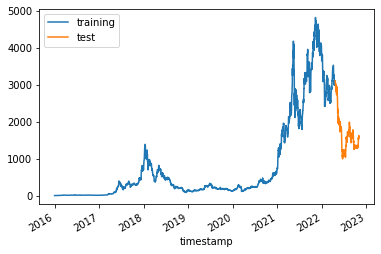

(287, 1)


In [14]:
#split dataframe in training and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1, shuffle=False)
train['open'].plot(legend=True)
test['open'].plot(legend=True)
plt.legend(['training', 'test'])
plt.show()
print(test.shape)

In [15]:
train

,open
timestamp,
2016-01-01 00:00:00,0.920000
2016-01-02 00:00:00,0.954700
2016-01-03 00:00:00,0.960000
2016-01-04 00:00:00,0.950000
2016-01-05 00:00:00,0.942600
...,...
2022-04-16 00:00:00,3040.192384
2022-04-17 00:00:00,3060.454980
2022-04-18 00:00:00,2988.683316


In [16]:
#Normalize training set
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [17]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 30
X_train = []
Y_train = []
m = len(train_scaled)


In [18]:
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(train_scaled[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(train_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape)
print(X_train)
print(Y_train)
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(X_train)

(2550, 30)
[[0.00000000e+00 7.21266769e-06 8.31431434e-06 ... 3.38808309e-04
  3.09708209e-04 3.15943945e-04]
 [7.21266769e-06 8.31431434e-06 6.23573575e-06 ... 3.09708209e-04
  3.15943945e-04 2.66058059e-04]
 [8.31431434e-06 6.23573575e-06 4.69758760e-06 ... 3.15943945e-04
  2.66058059e-04 2.59822323e-04]
 ...
 [6.45042897e-01 6.54177468e-01 6.54220975e-01 ... 6.27923074e-01
  6.31736649e-01 6.35948389e-01]
 [6.54177468e-01 6.54220975e-01 6.85012638e-01 ... 6.31736649e-01
  6.35948389e-01 6.21030085e-01]
 [6.54220975e-01 6.85012638e-01 6.84965817e-01 ... 6.35948389e-01
  6.21030085e-01 6.35068266e-01]]
[2.66058059e-04 2.59822323e-04 3.18022523e-04 ... 6.21030085e-01
 6.35068266e-01 6.44843951e-01]
(2550, 30, 1)
[[[0.00000000e+00]
  [7.21266769e-06]
  [8.31431434e-06]
  ...
  [3.38808309e-04]
  [3.09708209e-04]
  [3.15943945e-04]]

 [[7.21266769e-06]
  [8.31431434e-06]
  [6.23573575e-06]
  ...
  [3.09708209e-04]
  [3.15943945e-04]
  [2.66058059e-04]]

 [[8.31431434e-06]
  [6.23573575e-

Build and train RNN

In [19]:
#  LSTM Network

Input_shape = (X_train.shape[1],1)
Output_shape = 1
na = 30

model = Sequential()
model.add(LSTM(units=na, input_shape=Input_shape))
model.add(Dense(units=Output_shape))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [20]:
#here we set some callbacks for training and execute the training
callbacks = [EarlyStopping(monitor='loss', mode='min', verbose=1,patience=5),ModelCheckpoint(filepath='model.hdf5',monitor='val_loss', save_best_only=True, verbose=1,mode='min')]
model.compile(optimizer='rmsprop', loss='mse')
history=model.fit(X_train,Y_train,epochs=50,batch_size=60,callbacks=callbacks)

Epoch 1/50
43/43 [==============================] - 3s 15ms/step - loss: 0.0281
Epoch 2/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 3/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 4/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 5/50
43/43 [==============================] - 1s 14ms/step - loss: 6.5289e-04
Epoch 6/50
43/43 [==============================] - 1s 14ms/step - loss: 6.6542e-04
Epoch 7/50
43/43 [==============================] - 1s 17ms/step - loss: 5.2213e-04
Epoch 8/50
43/43 [==============================] - 1s 21ms/step - loss: 5.6396e-04
Epoch 9/50
43/43 [==============================] - 1s 20ms/step - loss: 4.9318e-04
Epoch 10/50
43/43 [==============================] - 1s 17ms/step - loss: 4.6509e-04
Epoch 11/50
43/43 [==============================] - 1s 16ms/step - loss: 4.2097e-04
Epoch 12/50
43/43 [==============================] - 1s 16ms/step - loss: 3.5392e-04
Epoch

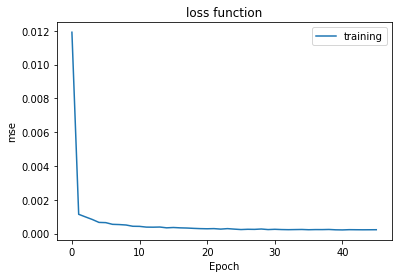

In [21]:
# Gráficar la función de pérdida
plt.plot(history.history['loss'])
plt.title('loss function')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['training'], loc='upper right')
plt.show()

Test model with test data

In [22]:
# Test (predicción del valor de las acciones)
x_test = test.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])

In [23]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(257, 30, 1)


In [24]:
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

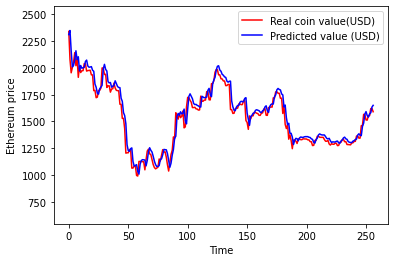

In [25]:

# Funciones auxiliares
def graficar_predicciones(real, prediccion):
    plt.plot(real,color='red', label='Real coin value(USD)')
    plt.plot(prediccion, color='blue', label='Predicted value (USD)')
    plt.ylim(1.1 * np.min(real)/2, 1.1 * np.max(real))
    plt.xlabel('Time')
    plt.ylabel('Ethereum price')
    plt.legend()
    plt.show()

graficar_predicciones(np.delete(test.values,[range(30)]),prediccion)

Now we'll use the model to predict the next 30 values of ethereum 

In [26]:
#using the model to actually predict values in future
x=test.values[-60:]
x=sc.transform(x)
    
X = np.array(x)
X = np.reshape(X,(1,X.shape[0],X.shape[1]))

X.shape

(1, 60, 1)

In [27]:
Prediction=model.predict(X) 
Prediction=sc.inverse_transform(Prediction)
Prediction

array([[1629.2498]], dtype=float32)

In [28]:
future_values = x

for i in range(5):
    a=model.predict(X) 
    future_values = np.append(future_values,a,axis=0)
    future_values = np.delete(future_values,0,axis=0)
    X=np.reshape(future_values,(1,future_values.shape[0],future_values.shape[1]))

future_values = sc.inverse_transform(future_values)
future_values

array([[1328.19162645],
       [1311.70668669],
       [1311.03258902],
       [1275.35730583],
       [1277.06433428],
       [1323.08250705],
       [1323.75958598],
       [1361.99656761],
       [1362.7336867 ],
       [1352.68846079],
       [1351.94085863],
       [1352.2726505 ],
       [1351.95626696],
       [1331.02894868],
       [1315.46027391],
       [1315.67336158],
       [1323.4089654 ],
       [1290.05412618],
       [1279.87      ],
       [1292.523457  ],
       [1287.86      ],
       [1286.98      ],
       [1296.88      ],
       [1296.67      ],
       [1274.77      ],
       [1276.5       ],
       [1306.02920816],
       [1306.55809846],
       [1331.51225216],
       [1333.22933184],
       [1310.99120923],
       [1312.01105146],
       [1285.10628171],
       [1284.5953417 ],
       [1282.96996645],
       [1282.10562968],
       [1300.07168007],
       [1300.62623008],
       [1314.02874737],
       [1314.5076423 ],
       [1364.17506385],
       [1364.062

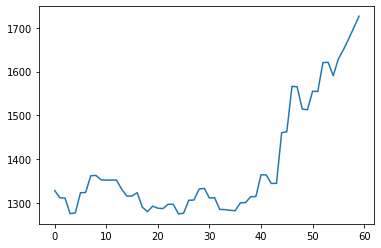

In [29]:

ddd=np.concatenate((future_values),axis=0)
plt.plot(ddd)


# Credits

ethereumprice.org provided the data for this model